# Example 2

![mlr](../images/mlr.png)


### A logistic Regression can classify between multiple labels?

As we were seeing in the last lesson, logistic regression is a binary classifier. So how do we use logistic regression if we have more labels, more classes?. The solution is using a logistic regression for each one of them. Imagine we want classify movies according to its genre, then we make a logistic regression for every single genre. It's that genre or it is not. The highest probability among all logistic regression is the selected prediction output. This method is called **One-vs-All**. 

If you want to know more about the mathematics behind logistic regression, take a look to this [notebook](https://github.com/YonatanRA/da-ce-case-study/blob/master/01-lesson-plans/3.08_multi_class_logistic_regression/ipynb/3.8.3%20-%20Logistic%20Regression%20Mathematics.ipynb), it is an example of handwritten numbers (MNIST data) classification.



![telecom](../images/telecom.jpeg)


Let's come back to the telecom company at we were working. Now, the churn model is running, kind of..😅, and the management ask for another project. This idea is part of a bigger marketing plan, but they need to know what kind of contract offer to the customers. 

So idea is to build a predictive model for the kind of contract. The contract types are monthly, one year or two year. We have three different classes or labels. As we were saying, we need to build three differents logistic regressions:

+ Is it a monthly contract or not?
+ Is it a one year contract or not?
+ Is it a two year contract or not?

These are our three classifiers in plain english. The output will be a three elements array and we will choose the highest value as our prediction. Scikit-Learn does all of this for us. 

First we will import our libraries.


In [1]:
import pandas as pd                                # panel data, for handling dataframes
pd.set_option('display.max_columns', None)         # show all columns of the dataframe

import numpy as np                                 # numerical python, linear algebra library

import pylab as plt                                # plotting library
import seaborn as sns                              # plotting library
sns.set(style='white')                             # seaborn style

from sqlalchemy import create_engine               # connection engine for SQL server


from sklearn.linear_model import LogisticRegression            # logistic regression model            
from sklearn.preprocessing import StandardScaler               # standarized
from sklearn.preprocessing import LabelEncoder               
from sklearn.model_selection import train_test_split as tts    # split data into train and test sets


from sklearn.metrics import confusion_matrix as cm      # confusion matrix for evaluation
from sklearn.metrics import f1_score as f1              # F1-score for evaluation

from sklearn.feature_selection import RFE               # recursive feature elimination

### Accesing data

Again, we make the connection to SQL server and load that temporary table we had in our database.

In [2]:
DB_LANG='mysql'             # database language

DRIVER='pymysql'            # database driver

USER='root'                 # user name

PASSWORD='password'         # user password

HOST='localhost'            # host SQL server

PORT='3306'                 # host port

SCHEMA='telcom'             # database schema name

In [3]:
connection_string=f'{DB_LANG}+{DRIVER}://{USER}:{PASSWORD}@{HOST}:{PORT}/{SCHEMA}'

        
engine=create_engine(connection_string)   # connection engine

In [4]:
df=pd.read_sql('select * from temporary_table', engine)

### EDA

We already did the EDA process before. But we need to know more about our new target, the `Contract` type.

In [5]:
df.Contract.value_counts()

Month-to-month    27416
Two year          11920
One year          10416
Name: Contract, dtype: int64

In [6]:
df.Contract.value_counts()/len(df)

Month-to-month    0.551053
Two year          0.239588
One year          0.209358
Name: Contract, dtype: float64

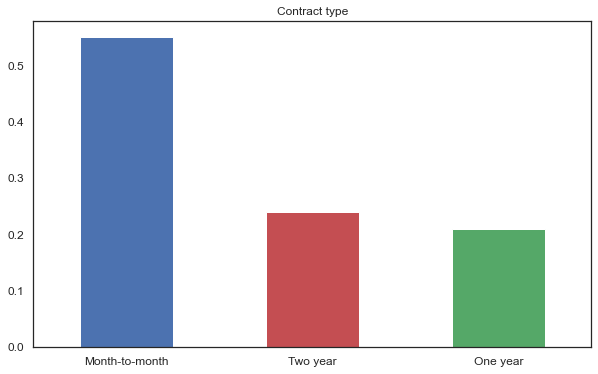

In [7]:
(df.Contract.value_counts()/len(df)).plot.bar(color=['b', 'r', 'g'],    
                                           figsize=(10, 6),
                                           title='Contract type',
                                           rot=0,
                                           fontsize=12);

Our main customers have monthly contracts, 55% of them. As we were discussing, the imbalance among classes generate a bias in the model. We will try to fix later. Now, we'll make the same data transformation as before.

### Data transformation

In [8]:
def change_all_dtypes(df):   
    '''
    This function change all dtypes to float if it can.
    
    input param df:  dataframe to be change
    
    returns: clean dataframe
    '''
    
    for c in df.columns:
        try:
            df[c]=df[c].astype(float)
        except:
            continue
            
    return df

In [9]:
df=change_all_dtypes(df)   # change dtypes

In [10]:
# dropping columns

data=df.drop(columns=['CustomerID',
                      'MonthlyMinutes',
                      'HandsetModels',
                      'id',
                      'Handsets',
                      'ReceivedCalls',
                      'MonthsInService',
                      'ServiceArea'
                     ])

In [11]:
data_num=pd.DataFrame(StandardScaler().fit_transform(data._get_numeric_data()),  # standardize numeric columns
                      columns=data._get_numeric_data().columns)

data_obj=data.select_dtypes(include='object')  # get categoric columns


data=pd.concat([data_num, data_obj], axis=1)   # concatenate both dataframes

In [12]:
# label encoding 

le=LabelEncoder()

for c in data.columns:
    if data.dtypes[c]==object:
        le.fit(data[c].astype(str))
        data[c]=le.transform(data[c].astype(str))

In [13]:
data.shape     # dataframe dimensions

(49752, 67)

In [14]:
data.head()

,MonthlyRevenue,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,DroppedCalls,BlockedCalls,UnansweredCalls,CustomerCareCalls,ThreewayCalls,OutboundCalls,InboundCalls,PeakCallsInOut,OffPeakCallsInOut,DroppedBlockedCalls,CallForwardingCalls,CallWaitingCalls,UniqueSubs,ActiveSubs,CurrentEquipmentDays,AgeHH1,AgeHH2,RetentionCalls,RetentionOffersAccepted,ReferralsMadeBySubscriber,IncomeGroup,AdjustmentsToCreditRating,SeniorCitizen,Tenure,Churn,ChildrenInHH,HandsetRefurbished,HandsetWebCapable,TruckOwner,RVOwner,Homeownership,BuysViaMailOrder,RespondsToMailOffers,OptOutMailings,NonUSTravel,OwnsComputer,HasCreditCard,NewCellphoneUser,NotNewCellphoneUser,OwnsMotorcycle,HandsetPrice,MadeCallToRetentionTeam,CreditRating,PrizmCode,Occupation,MaritalStatus,Gender,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,TenureLevel
0,-0.783391,-1.045275,-0.288506,-0.413714,-0.124522,-0.568070,-0.452482,-0.587674,-0.311711,-0.565902,-0.366649,-0.254828,-0.723803,-0.492182,-0.310234,-0.471357,-0.572545,-0.020214,-0.274974,0.384227,-0.525372,-0.075394,1.387951,-0.883862,4.775674,-0.128321,-0.193162,-0.129459,-0.140293,-0.438968,1.327621,1,0,0,1,0,0,0,1,1,0,0,1,1,0,0,0,8,1,0,2,4,0,0,0,0,0,2,2,2,2,2,2,2,1,0,3
1,-0.941570,-1.255720,-0.400881,-0.413714,-0.124522,0.029924,0.029852,-0.631939,-0.376308,-0.658542,-0.366649,-0.254828,-0.723803,-0.492182,-0.816926,-0.719375,-0.637245,-0.020214,-0.328636,-0.431548,-0.525372,4.455151,0.392087,0.871525,-0.175756,-0.128321,-0.193162,0.192036,-0.140293,-0.438968,0.838668,1,1,0,0,0,0,0,1,1,0,0,1,1,1,0,0,8,0,3,2,4,2,1,0,1,0,2,2,0,2,0,0,1,0,1,0
2,-0.467484,-0.371853,-0.400881,-0.413714,-0.124522,0.037741,0.029852,-0.665137,-0.376308,-0.728022,-0.366649,-0.254828,-0.715237,-0.492182,-0.852299,-0.690260,-0.656655,-0.020214,-0.328636,-0.431548,-0.525372,5.675981,-0.241644,0.202806,-0.175756,-0.128321,-0.193162,0.513532,-0.140293,-0.438968,-1.280129,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,15,0,2,3,1,2,0,0,0,0,0,0,0,0,0,2,0,1,2,1
3,0.531686,1.185434,0.156497,-0.413714,-0.124522,0.659185,0.235479,5.089263,0.334262,1.227715,0.474635,0.855266,9.849010,8.370346,4.447898,2.544760,3.205954,-0.020214,3.731853,0.384227,0.972010,0.309088,-0.060578,-0.883862,-0.175756,-0.128321,-0.193162,0.513532,-0.140293,-0.438968,0.105238,0,0,0,1,0,0,0,1,1,0,0,0,1,1,0,0,0,0,3,0,3,0,0,1,1,2,1,1,1,1,1,1,2,0,1,2
4,-0.938185,-1.255720,-0.400881,-0.413714,-0.124522,0.045558,0.024775,-0.665137,-0.376308,-0.728022,-0.366649,-0.254828,-0.723803,-0.492182,-0.864728,-0.730159,-0.656655,-0.020214,-0.328636,0.384227,0.972010,1.870799,0.663686,1.373064,-0.175756,-0.128321,-0.193162,1.478017,2.472906,-0.438968,-0.017000,1,0,0,0,0,0,0,1,1,0,0,1,1,0,1,0,0,0,0,0,4,2,0,0,0,1,2,0,2,2,2,2,1,1,0,0


### Modeling

We have again the data prepared to modeling. The first thing we need to do is split the data into the X features and the y target (contract).

In [15]:
X=data.drop('Contract', axis=1)   # all data except target

y=data.Contract               # target data

In [16]:
y.unique()   # 3 labels

array([2, 1, 0])

Now we split the data into train and test datasets in order to train the model and then evaluate it.

In [17]:
X_train, X_test, y_train, y_test=tts(X, y, random_state=42)   # split data into train and test sets

It is time to call our `LogisticRegression` and fit it. This time the sklearn package will do the job for all labels.

In [18]:
# logistic regression model

logreg=LogisticRegression(max_iter=2000)

logreg.fit(X_train, y_train)

LogisticRegression(max_iter=2000)

From this point we are able to make our customer contract type predictions.

In [19]:
y_pred=logreg.predict(X_test)   # predictions

y_pred[:10]

array([2, 0, 0, 1, 0, 2, 1, 2, 0, 2])

### Evaluation

Firts, we take a look to the model **accuracy**.

In [20]:
logreg.score(X_train, y_train)    # accuracy in train dataset

0.7336120490968537

In [21]:
logreg.score(X_test, y_test)      # accuracy in test dataset

0.7306640939057726

In practice, for multilabel classification model, which is our case, accuracy is mostly favored. F1-score is usually used for multilabel or binary label where the classes are highly unbalanced.

+ Accuracy is used when the True Positives and True negatives are more important while F1-score is used when the False Negatives and False Positives are crucial.

+ Accuracy can be used when the class distribution is similar while F1-score is a better metric when there are imbalanced classes as in the above case.

+ In most real-life classification problems, imbalanced class distribution exists and thus F1-score is a better metric to evaluate our model on.


**F1-Score**

Pros :

+ Takes into account how the data is distributed. Useful when you have data with imbalance classes.

Cons :

+ Less interpretable. Precision and recall is more interpretable than f1-score, since it measures the type-1 error and type-2 error. However, f1-score measures the trade-off between this two.
When positive class is minority class, the score is quite sensitive when there is switching where the ground truth is positive.


**Accuracy**

Pros :

+ Easy to understand.


Cons :

+ It does not take into account how the data is distributed. This error could be crucial and might lead to incorrect conclusion.


Let's take a look to the F1-Score.

In [22]:
f1(y_test, y_pred, average='macro')    # F1-score multilabel

0.6270994493160625

Our F1-Score value is less than the accuracy. That means our model is confused about some label. Let's take a look to the **confusion matrix** to realize what is going on.

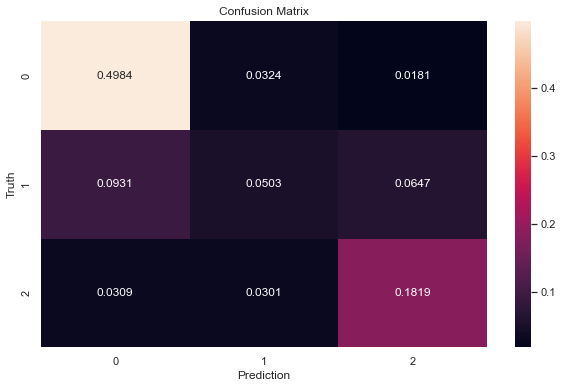

In [23]:
conf_matrix_rate=cm(y_test, y_pred)/sum(sum(cm(y_test, y_pred)))    # confusion matrix as a rate


fig, ax=plt.subplots(figsize=(10,6))

ax=sns.heatmap(conf_matrix_rate, 
               annot=True, 
               fmt='.4f',
               ax=ax)

plt.title('Confusion Matrix')
plt.ylabel('Truth')
plt.xlabel('Prediction')
plt.show();

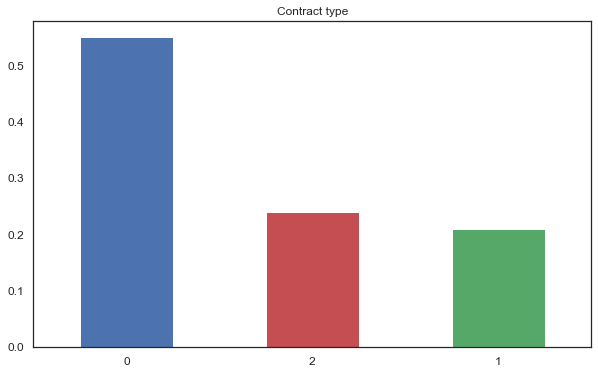

In [24]:
(y.value_counts()/len(y)).plot.bar(color=['b', 'r', 'g'],    
                                           figsize=(10, 6),
                                           title='Contract type',
                                           rot=0,
                                           fontsize=12);

As we can see, the model is almost blind to the label `1`, the one year contract type. 50% of our accuracy is because we are predicting label `0`, monthly contracts, the most part of our data. Again we have a bias in the model. Let's make some feature experiments to try avoid the bias.

### RFE


Maybe we are not selecting the good features for our model. Can we do something? 

RFE is a transformer estimator, which means it follows the familiar fit/transform pattern of Sklearn. It is a popular algorithm due to its easy configurable nature and robust performance. As the name suggests, it removes features one at a time based on the weights given by a model of our choice in each iteration. Will it work? Let's try.

In [25]:
selector=RFE(logreg, n_features_to_select=15, step=1)   # rfe definition and fitting
selector.fit(X, y)

RFE(estimator=LogisticRegression(max_iter=2000), n_features_to_select=15)

In [26]:
selector.ranking_     # features ranking

array([22, 24, 38, 23, 26, 28, 29,  1,  1, 34, 51, 35, 27, 30, 46, 44,  1,
       31, 41, 36, 20, 47, 16, 43, 18, 19, 42, 39, 49,  1,  1, 15, 13, 48,
        8, 21, 12,  5,  9, 10,  4,  2,  3,  6, 32, 14, 25, 52, 17, 50, 45,
       40, 33, 11,  7,  1,  1,  1,  1,  1,  1,  1,  1,  1, 37,  1])

In [27]:
X_rfe=selector.transform(X)    # data transform

At this point, we have changed our data, dropping columns in a recursive way.

In [28]:
X_rfe.shape

(49752, 15)

In [29]:
X_train, X_test, y_train, y_test=tts(X_rfe, y, random_state=42)

Training the model with the neew dataset.

In [30]:
logreg_ref=LogisticRegression(max_iter=2000)

logreg_ref.fit(X_train, y_train)

train_score=logreg_ref.score(X_train, y_train) 
test_score=logreg_ref.score(X_test, y_test)

print ('train Acc:',train_score, '-- test Acc:', test_score)

train Acc: 0.7313876829072198 -- test Acc: 0.7301817012381412


In [31]:
y_pred_ref=logreg_ref.predict(X_test)

In [32]:
f1(y_test, y_pred_ref, average='macro')

0.6258866750983468

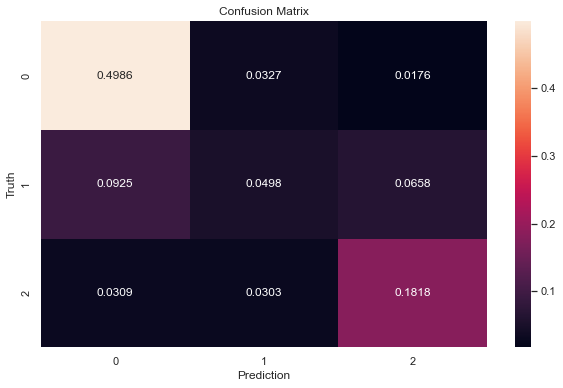

In [33]:
conf_matrix_rate=cm(y_test, y_pred_ref)/sum(sum(cm(y_test, y_pred_ref)))    

fig, ax=plt.subplots(figsize=(10,6))

ax=sns.heatmap(conf_matrix_rate, 
               annot=True, 
               fmt='.4f',
               ax=ax)

plt.title('Confusion Matrix')
plt.ylabel('Truth')
plt.xlabel('Prediction')
plt.show();

We have the same problem, we have a bias. But the accuracy and F1-Score have not drop so much. This means we can use RFE for computer optimization if we need to.

### PCA

We can try in the same way with PCA. Remember PCA is not about dropping columns, but a data transformation. 

In [34]:
from sklearn.decomposition import PCA

We need to know the explained variance ratio in order to know our target dimensions.

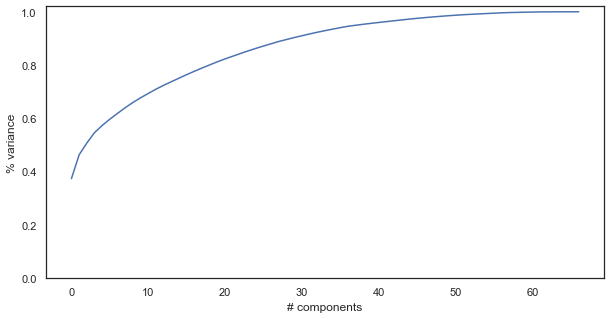

In [35]:
pca=PCA()

pca.fit(data)

plt.figure(figsize=(10, 5))

plt.plot(np.cumsum(pca.explained_variance_ratio_))

plt.xlabel('# components')
plt.ylabel('% variance')
plt.ylim([0, 1.02]);

Seeing this plot, could be reasonable the range [40-50] for number of components. Let's try with 45.

In [36]:
pca=PCA(n_components=45)

X_pca=pca.fit_transform(X)

In [37]:
X_train, X_test, y_train, y_test=tts(X_pca, y, random_state=42)

In [38]:
logreg_pca=LogisticRegression(max_iter=2000)

logreg_pca.fit(X_train, y_train)

train_score=logreg_pca.score(X_train, y_train) 
test_score=logreg_pca.score(X_test, y_test)

print ('train Acc:',train_score, '-- test Acc:', test_score)

train Acc: 0.7289221203837701 -- test Acc: 0.7274481427882297


In [39]:
y_pred_pca=logreg_pca.predict(X_test)

In [40]:
f1(y_test, y_pred_ref, average='macro')

0.6258866750983468

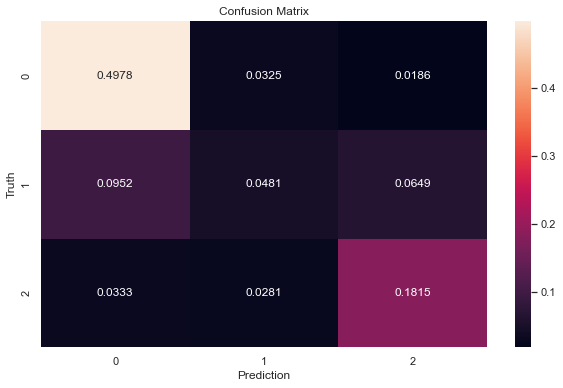

In [41]:
conf_matrix_rate=cm(y_test, y_pred_pca)/sum(sum(cm(y_test, y_pred_pca)))    

fig, ax=plt.subplots(figsize=(10,6))

ax=sns.heatmap(conf_matrix_rate, 
               annot=True, 
               fmt='.4f',
               ax=ax)

plt.title('Confusion Matrix')
plt.ylabel('Truth')
plt.xlabel('Prediction')
plt.show();

We still have the bias problem. Can we fix it? Can we balance the labels?

### Smote (oversampling)

Oversampling involves supplementing the training data with multiple copies of some of the minority classes. There are a number of methods available to oversample a dataset used in a typical classification problem. The most common technique is known as **SMOTE: Synthetic Minority Over-sampling Technique**.

To illustrate how this technique works consider some training data which has s samples, and f features in the feature space of the data. Note that these features, for simplicity, are continuous. As an example, consider a dataset of birds for classification. The feature space for the minority class for which we want to oversample could be beak length, wingspan, and weight, all continuous. To then oversample, take a sample from the dataset, and consider its k nearest neighbors, in feature space. To create a synthetic data point, take the vector between one of those k neighbors, and the current data point. Multiply this vector by a random number x which lies between 0, and 1. Add this to the current data point to create the new, synthetic data point.


Let's try SMOTE algorithm.

In [42]:
from imblearn.over_sampling import SMOTE

In [43]:
oversample=SMOTE(sampling_strategy='not majority')

X_smote, y_smote=oversample.fit_resample(X, y)

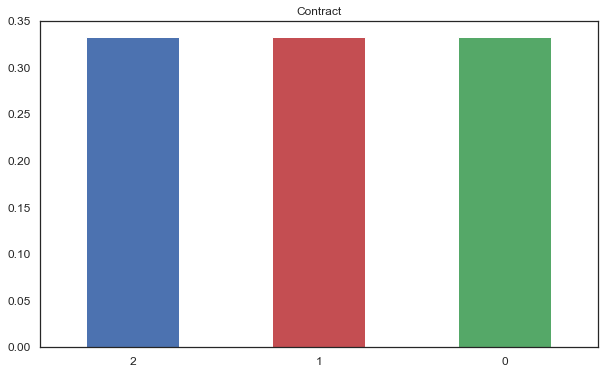

In [44]:
(y_smote.value_counts()/len(y_smote)).plot.bar(color=['b', 'r', 'g'],   
                                           figsize=(10, 6),
                                           title='Contract',
                                           rot=0,
                                           fontsize=12);

Now we have balanced the classes. We'll train the logistic regression model.

In [45]:
X_train, X_test, y_train, y_test=tts(X_smote, y_smote, random_state=42)

In [46]:
logreg_smote=LogisticRegression(max_iter=2000)

logreg_smote.fit(X_train, y_train)

train_score=logreg_smote.score(X_train, y_train) 
test_score=logreg_smote.score(X_test, y_test)

print ('train Acc:',train_score, '-- test Acc:', test_score)

train Acc: 0.7057354991408099 -- test Acc: 0.7077618908666472


In [47]:
y_pred_smote=logreg_smote.predict(X_test)

In [48]:
f1(y_test, y_pred_smote, average='macro')

0.7069549350594294

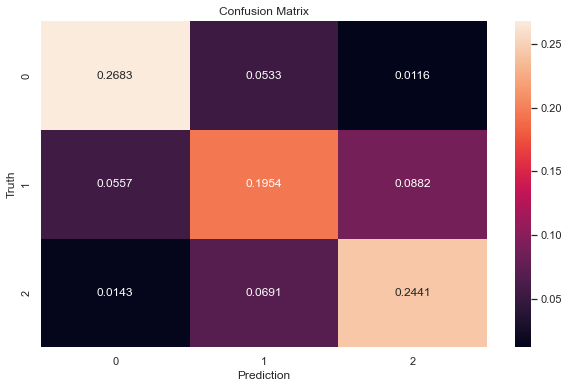

In [49]:
conf_matrix_rate=cm(y_test, y_pred_smote)/sum(sum(cm(y_test, y_pred_smote)))    

fig, ax=plt.subplots(figsize=(10,6))

ax=sns.heatmap(conf_matrix_rate, 
               annot=True, 
               fmt='.4f',
               ax=ax)

plt.title('Confusion Matrix')
plt.ylabel('Truth')
plt.xlabel('Prediction')
plt.show();

We see the accuracy dropped a bit, but our F1-Score is better and the confusion matrix shows a fix in the bias problem. Therefore, this model has less accuracy but it is a more robust classifier, now it is not blind to the `1` label.

### Other models

We can try another models, like random forests or boosting models. We'll continue with the SMOTE data to check another models, accuracy, F1-Score and confusion matrix.

In [50]:
X_train, X_test, y_train, y_test=tts(X_smote, y_smote, random_state=42)

In [51]:
from sklearn.ensemble import RandomForestClassifier as RFC


rfc=RFC()
rfc.fit(X_train, y_train)

train_score=rfc.score(X_train, y_train) 
test_score=rfc.score(X_test, y_test)

print ('train Acc:',train_score, '-- test Acc:', test_score)

train Acc: 1.0 -- test Acc: 0.8572609668320202


In [52]:
y_pred=rfc.predict(X_test)

In [53]:
f1(y_test, y_pred, average='macro')

0.8580123747128413

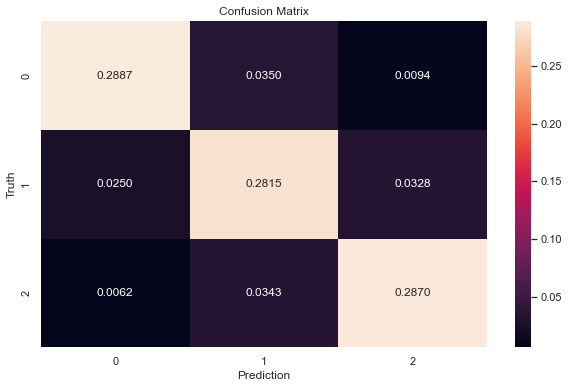

In [54]:
conf_matrix_rate=cm(y_test, y_pred)/sum(sum(cm(y_test, y_pred)))    

fig, ax=plt.subplots(figsize=(10,6))

ax=sns.heatmap(conf_matrix_rate, 
               annot=True, 
               fmt='.4f',
               ax=ax)

plt.title('Confusion Matrix')
plt.ylabel('Truth')
plt.xlabel('Prediction')
plt.show();

**This model is doing very good job!!**

Let's try a boosting classifier.

In [55]:
from xgboost import XGBClassifier as XGBC

xgbc=XGBC(eval_metric='mlogloss',
          use_label_encoder=False)

xgbc.fit(X_train, y_train)

train_score=xgbc.score(X_train, y_train) 
test_score=xgbc.score(X_test, y_test)

print ('train Acc:',train_score, '-- test Acc:', test_score)

train Acc: 0.9008202833706189 -- test Acc: 0.8159712090263593


In [56]:
y_pred=xgbc.predict(X_test)

In [57]:
f1(y_test, y_pred, average='macro')

0.8159477340967145

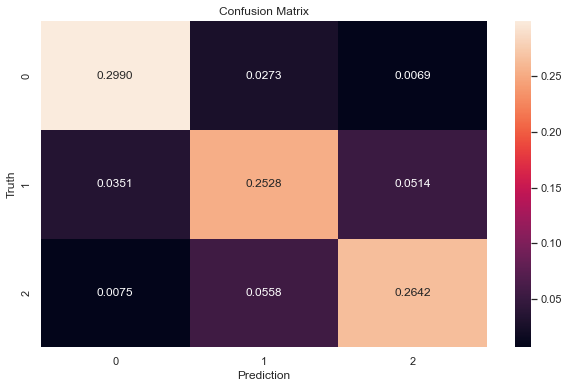

In [58]:
conf_matrix_rate=cm(y_test, y_pred)/sum(sum(cm(y_test, y_pred)))    

fig, ax=plt.subplots(figsize=(10,6))

ax=sns.heatmap(conf_matrix_rate, 
               annot=True, 
               fmt='.4f',
               ax=ax)

plt.title('Confusion Matrix')
plt.ylabel('Truth')
plt.xlabel('Prediction')
plt.show();

**What model do we choose?**